Skewed Columns (>|1| skewness): ['id', 'member_id', 'annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_accounts', 'out_prncp', 'out_prncp_inv', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_payment_amount', 'collections_12_mths_ex_med']

Applied boxcox transformation to id. Skewness after: -0.06136776732779664
Applied boxcox transformation to member_id. Skewness after: -0.0688714850540478
Applied boxcox transformation to annual_inc. Skewness after: -0.011948183974555437
Applied boxcox transformation to open_accounts. Skewness after: 0.001819492598839149




C:\Users\tde_v\AppData\Local\Temp\ipykernel_11292\3831473981.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 4))


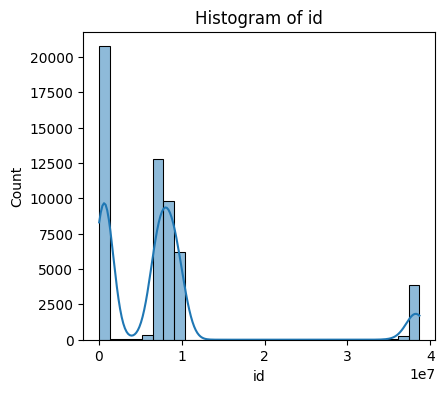

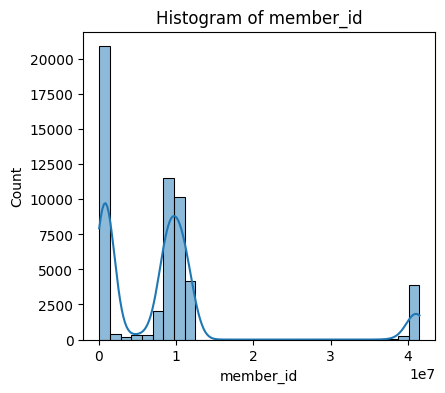

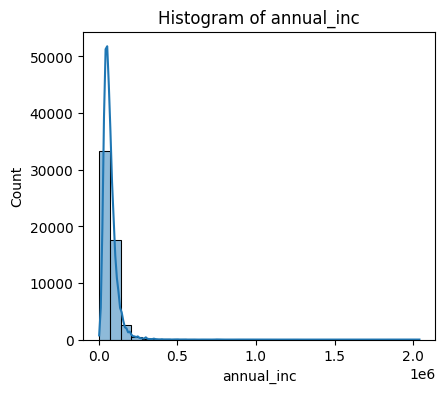

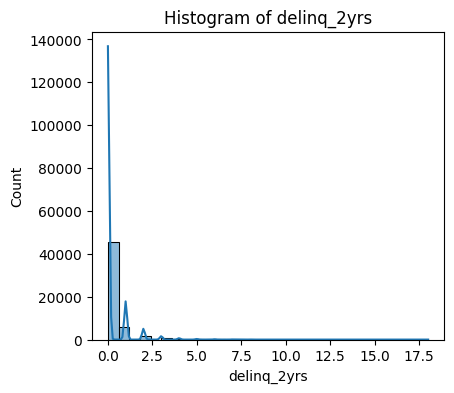

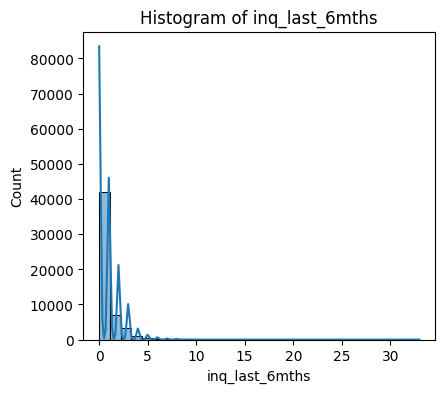

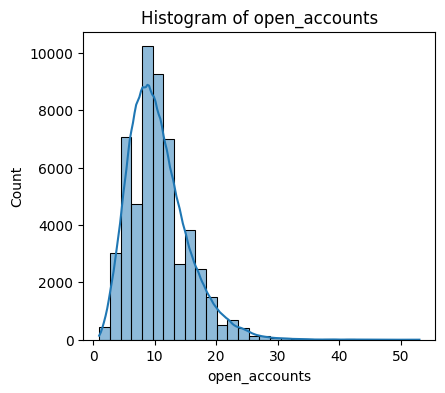

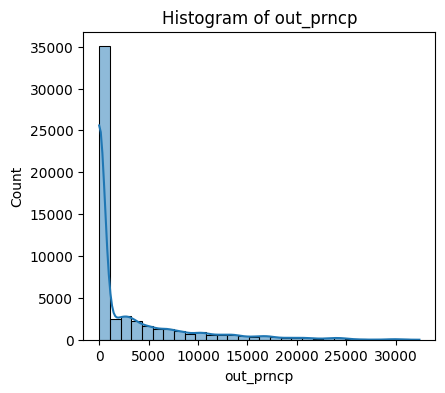

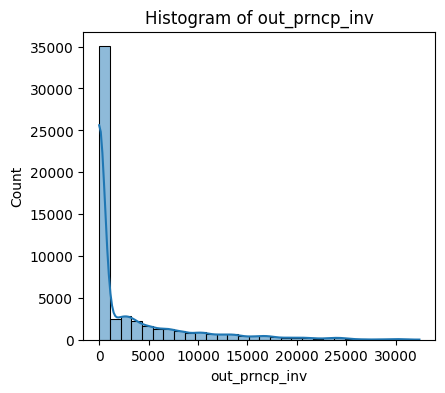

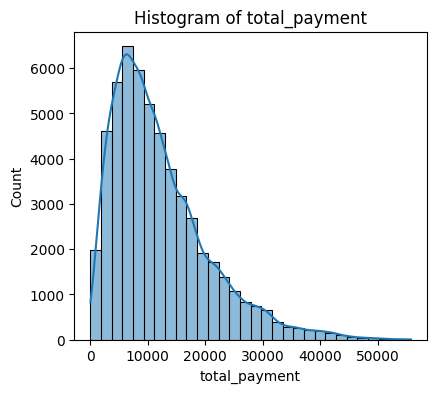

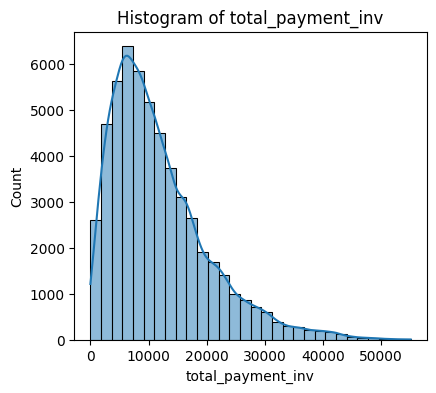

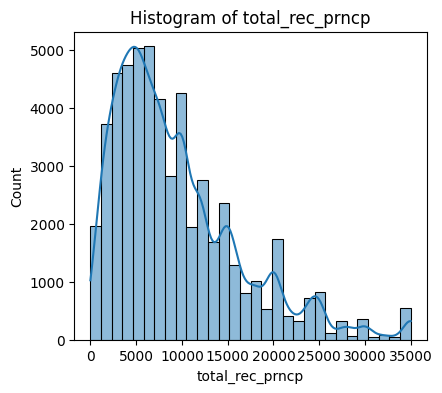

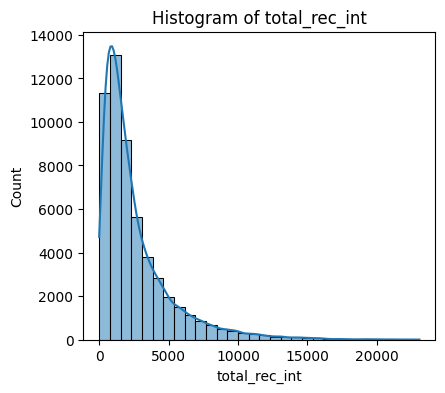

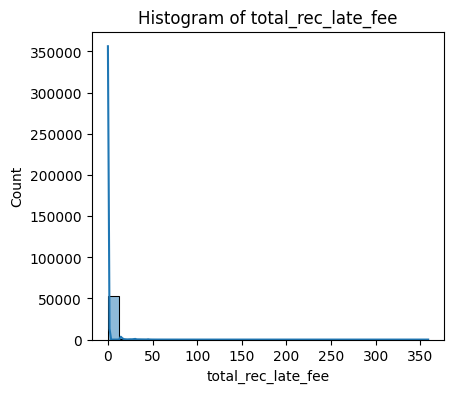

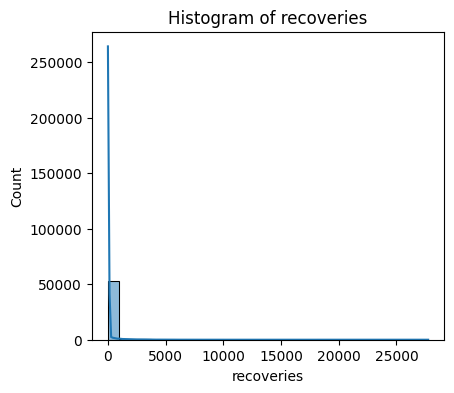

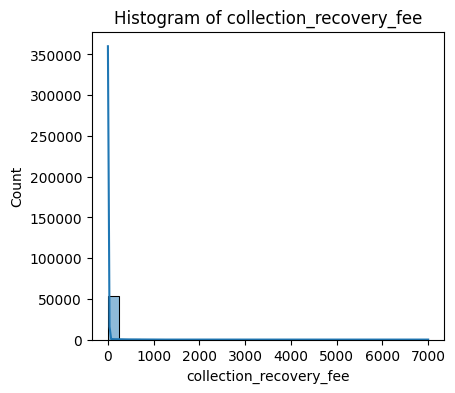

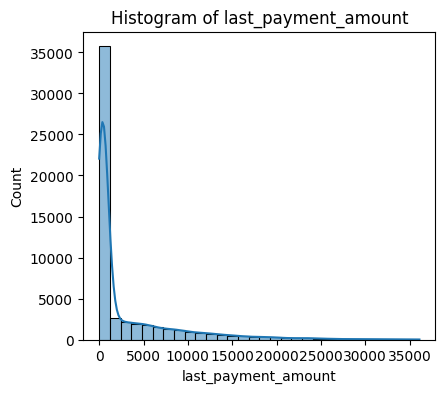

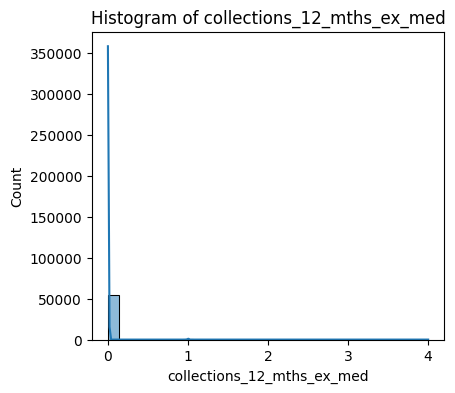

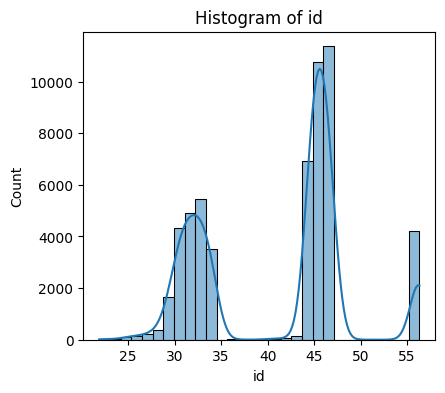

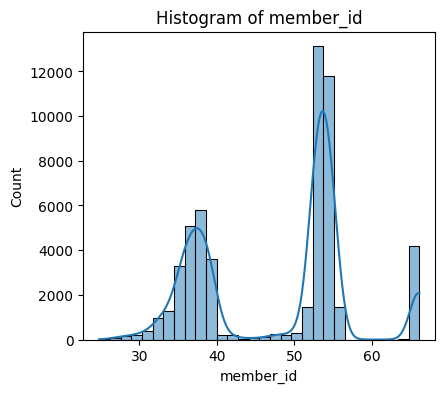

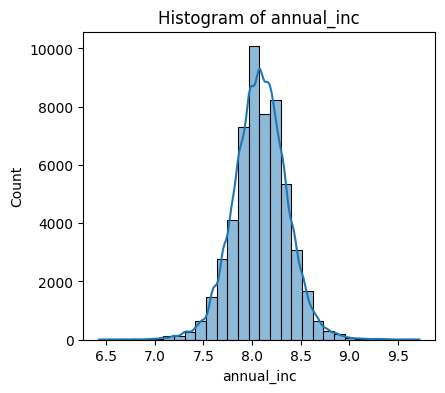

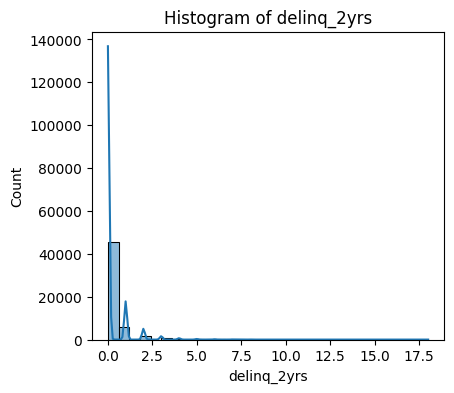

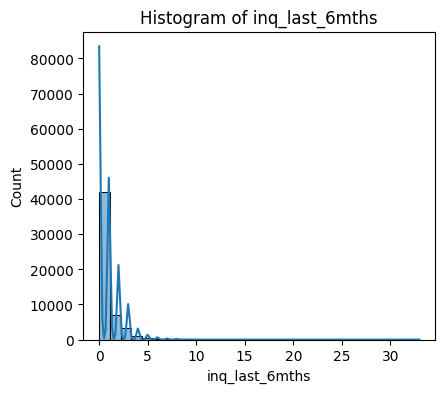

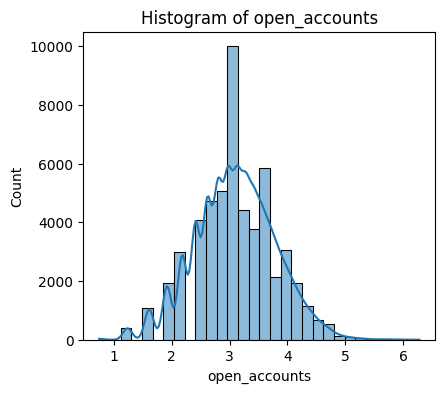

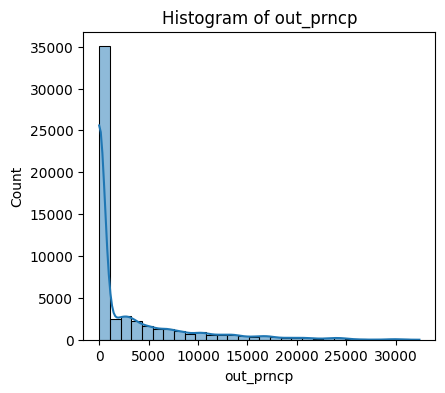

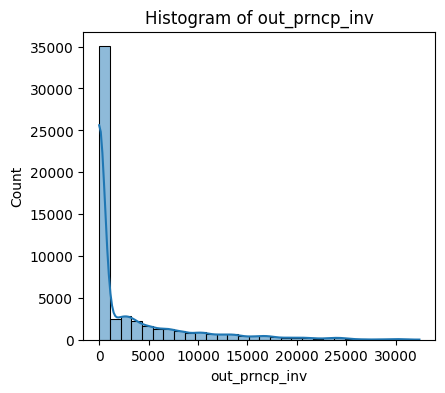

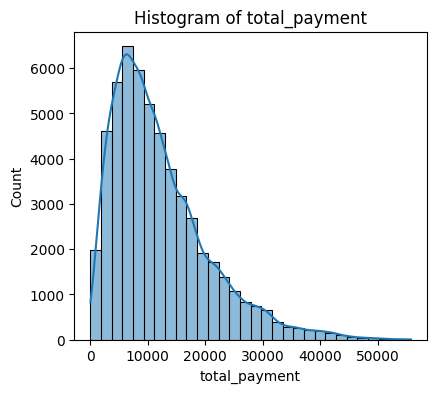

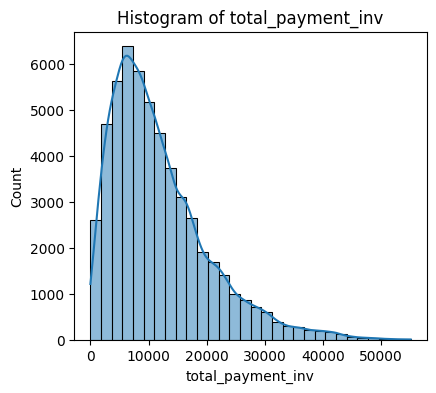

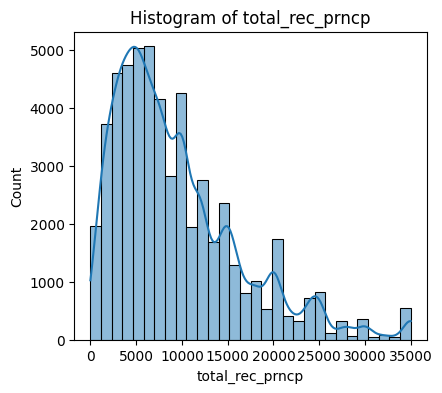

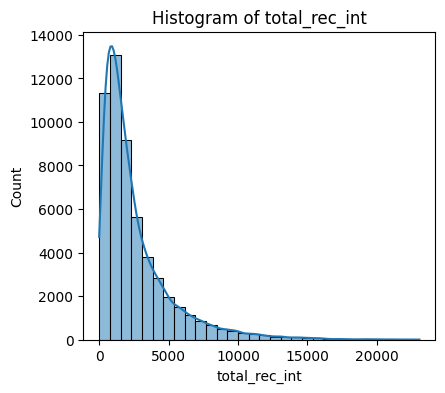

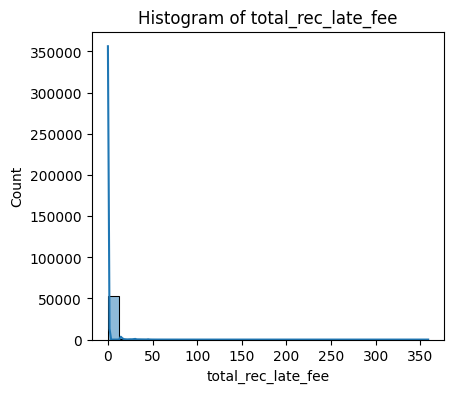

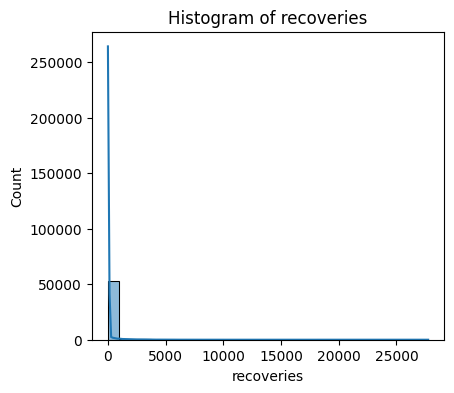

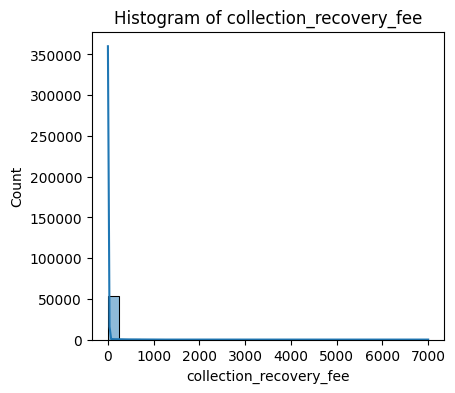

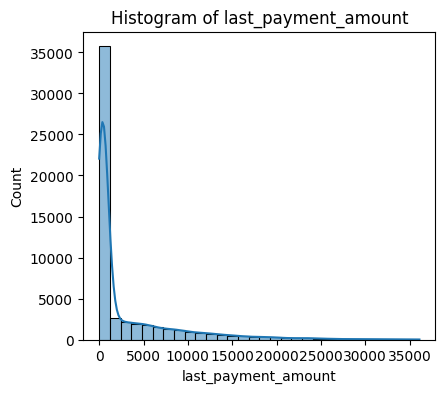

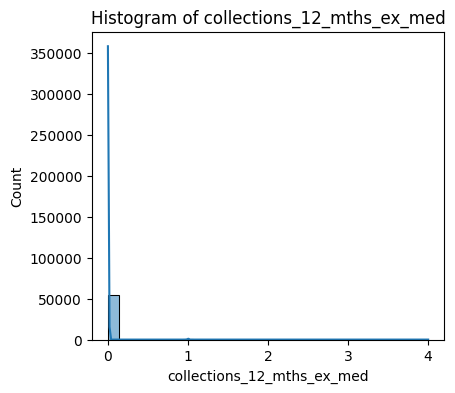

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
custloan_df = pd.read_csv(r'C:\Users\tde_v\CourseAI\customer_loans\loan_payments.csv')

class DataFrameInfo:
    def __init__(self, df):
        self.df = df

    def describe_columns(self):
        "Describe all columns in the DataFrame to check their data types"
        print("Column Descriptions:")
        print(self.df.dtypes)
        print("\n")

    def statistical_summary(self):
        "Extract statistical values: median, standard deviation and mean from the columns and the DataFrame"
        print("Statistical Summary:")
        print("Mean:\n", self.df.mean(numeric_only=True))
        print("\nMedian:\n", self.df.median(numeric_only=True))
        print("\nStandard Deviation:\n", self.df.std(numeric_only=True))
        print("\n")

    def count_distinct_values(self):
        "Count distinct values in categorical columns"
        categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns
        print("Distinct Values in Categorical Columns:")
        for col in categorical_cols:
            print(f"{col}: {self.df[col].nunique()} distinct values")
        print("\n")

    def print_shape(self):
        "Print out the shape of the DataFrame"
        print(f"The DataFrame has {self.df.shape[0]} rows and {self.df.shape[1]} columns.\n")

    def null_value_summary(self):
        "Generate a count/percentage count of NULL values in each column"
        print("NULL Value Summary:")
        null_counts = self.df.isnull().sum()
        null_percentage = (null_counts / len(self.df)) * 100
        null_summary = pd.DataFrame({
            'Null Count': null_counts,
            'Null Percentage': null_percentage
        })
        print(null_summary)
        print("\n")

class Plotter:
    def __init__(self, df):
        self.df = df

    def plot_nulls(self, null_summary_before, null_summary_after):
        "Visualise removal of NULL values with a bar plot."
        plt.figure(figsize=(12, 6))
        width = 0.20
        indices = np.arange(len(null_summary_before))

        plt.bar(indices, null_summary_before, width, label='Before NULL Removal', color='skyblue')
        plt.bar(indices + width, null_summary_after, width, label='After NULL Removal', color='salmon')

        plt.xticks(indices + width / 2, self.df.columns, rotation=90)
        plt.ylabel('Number of NULLs')
        plt.title('Comparison of NULL Counts Before and After Removal')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    def plot_skew(self, skewed_cols):
        """Plot histograms of skewed columns to analyze distribution."""
        for col in skewed_cols:
            plt.figure(figsize=(10, 4))

            # Histogram
            plt.subplot(1, 2, 1)
            sns.histplot(self.df[col], kde=True, bins=30)
            plt.title(f"Histogram of {col}")

class DataFrameTransform:
    def __init__(self, df):
        self.df = df

    def drop_high_null_columns(self, threshold=50):
        "Drop columns with a NULL percentage above the threshold."
        null_percentage = (self.df.isnull().sum() / len(self.df)) * 100
        columns_to_drop = null_percentage[null_percentage > threshold].index
        self.df.drop(columns=columns_to_drop, inplace=True)
        print(f"Dropped columns with >{threshold}% NULLs: {list(columns_to_drop)}\n")

    def impute_nulls(self):
        "Impute NULL values with the mean or median."
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if self.df[col].isnull().sum() > 0:
                # Use median for skewed columns and mean for others
                if abs(self.df[col].skew()) > 1:
                    self.df[col].fillna(self.df[col].median(), inplace=True)
                    print(f"Imputed column {col} with median.")
                else:
                    self.df[col].fillna(self.df[col].mean(), inplace=True)
                    print(f"Imputed column {col} with mean.")
        print("\n")
    
    def identify_skewed_columns(self, threshold=1):
        """Identify columns that have a skewness greater than the given threshold."""
        skewness = self.df.skew(numeric_only=True)
        skewed_cols = skewness[abs(skewness) > threshold].index.tolist()
        print(f"Skewed Columns (>|{threshold}| skewness): {skewed_cols}\n")
        return skewed_cols
    
    def transform_skewed_columns(self, skewed_cols):
        """Apply transformations to reduce skewness."""
        for col in skewed_cols:
            if (self.df[col] > 0).all(): 
                log_transformed = np.log1p(self.df[col])
                sqrt_transformed = np.sqrt(self.df[col])
                boxcox_transformed, _ = boxcox(self.df[col] + 1)

                # Choose transformation with the least skewness
                transformations = {
                    "log": log_transformed.skew(),
                    "sqrt": sqrt_transformed.skew(),
                    "boxcox": pd.Series(boxcox_transformed).skew(),
                }
                best_transformation = min(transformations, key=lambda k: abs(transformations[k]))

                # Apply the best transformation
                if best_transformation == "log":
                    self.df[col] = log_transformed
                elif best_transformation == "sqrt":
                    self.df[col] = sqrt_transformed
                else:
                    self.df[col] = boxcox_transformed

                print(f"Applied {best_transformation} transformation to {col}. Skewness after: {self.df[col].skew()}")

        print("\n")

# Instantiate classes
info = DataFrameInfo(custloan_df)
transform = DataFrameTransform(custloan_df)
plotter = Plotter(custloan_df)

# Identify skewed columns
skewed_columns = transform.identify_skewed_columns(threshold=1)
plotter.plot_skew(skewed_columns)

# Transform skewed columns
transform.transform_skewed_columns(skewed_columns)

# Visualize results
plotter.plot_skew(skewed_columns)